<a href="https://colab.research.google.com/github/pushkar-hue/Emotion_detection_using_ConvNeXt/blob/main/fer_using_ConvNeXt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fer2013


In [2]:
cd /kaggle/input/fer2013/

/kaggle/input/fer2013


In [3]:
ls

test/  train/


In [4]:
import os

def walk_through(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through(path)

There are 2 directories and 0 images in '/kaggle/input/fer2013'.
There are 7 directories and 0 images in '/kaggle/input/fer2013/test'.
There are 0 directories and 831 images in '/kaggle/input/fer2013/test/surprise'.
There are 0 directories and 1024 images in '/kaggle/input/fer2013/test/fear'.
There are 0 directories and 958 images in '/kaggle/input/fer2013/test/angry'.
There are 0 directories and 1233 images in '/kaggle/input/fer2013/test/neutral'.
There are 0 directories and 1247 images in '/kaggle/input/fer2013/test/sad'.
There are 0 directories and 111 images in '/kaggle/input/fer2013/test/disgust'.
There are 0 directories and 1774 images in '/kaggle/input/fer2013/test/happy'.
There are 7 directories and 0 images in '/kaggle/input/fer2013/train'.
There are 0 directories and 3171 images in '/kaggle/input/fer2013/train/surprise'.
There are 0 directories and 4097 images in '/kaggle/input/fer2013/train/fear'.
There are 0 directories and 3995 images in '/kaggle/input/fer2013/train/angry'

In [6]:
import numpy as np
import torch
import torch.nn as nn

In [7]:
train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'


In [8]:
import os
from torchvision import transforms, datasets
from torch.utils.data import DataLoader


In [9]:
# For training with augmentation
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# For testing (no augmentation)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [10]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transforms)


In [11]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [12]:
class_names = train_dataset.classes
print("Classes:", class_names)


Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [13]:
class_name = train_dataset.classes

class_name

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [14]:
class_idx = train_dataset.class_to_idx

class_idx

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
import torchvision

weights = torchvision.models.EfficientNet_B3_Weights.DEFAULT
model = torchvision.models.efficientnet_b3(weights=weights)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 90.9MB/s]


In [17]:
# Unfreeze more layers
for layer in list(model.features)[-5:]: # Try -8 or -10 instead of -5
    for param in layer.parameters():
        param.requires_grad = True

In [18]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


output_shape = len(train_dataset.classes)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.3, inplace=True),
    torch.nn.Linear(in_features=1536,
                    out_features=output_shape,
                    bias=True)).to(device)

In [19]:
import torch.optim as optim

criterion=nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)

In [20]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

In [21]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               scheduler: torch.optim.lr_scheduler._LRScheduler = None) -> Tuple[float, float]:

    model.train()

    train_loss, train_acc = 0.0, 0.0
    total_samples = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item() * X.size(0)  # Scale loss by batch size

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step(loss)  # Step the scheduler if provided

        current_lr = optimizer.param_groups[0]['lr']
        print(f"LR: {current_lr:.6f}")
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()
        total_samples += y.size(0)

    train_loss /= total_samples  # Normalize by total dataset size
    train_acc /= total_samples  # Normalize accuracy

    return train_loss, train_acc

In [22]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:


    model.eval()


    test_loss, test_acc = 0, 0


    with torch.inference_mode():

        for batch, (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)



            test_pred_logits = model(X)


            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))


    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [23]:
def train_and_validate(model,
                       train_loader,
                       val_loader,
                       criterion,
                       optimizer,
                       device,
                       num_epochs=50,
                       patience=5,
                       checkpoint_dir='./checkpoints',
                       scheduler=None): # Add scheduler argument
    """
    Train and validate the model with early stopping and checkpointing

    Args:
    - model: PyTorch model
    - train_loader: DataLoader for training data
    - val_loader: DataLoader for validation data
    - criterion: Loss function
    - optimizer: Optimizer
    - device: Computing device (cuda/cpu)
    - num_epochs: Maximum number of training epochs
    - patience: Number of epochs with no improvement after which training will be stopped
    - checkpoint_dir: Directory to save model checkpoints
    - scheduler: (Optional) Learning rate scheduler
    """
    # Create checkpoint directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Training history tracking
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    # Early stopping variables
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, train_acc = 0, 0

        train_progress_bar = tqdm(train_loader,
                                  desc=f'Epoch {epoch+1}/{num_epochs}',
                                  unit='batch')

        for batch, (X, y) in enumerate(train_progress_bar):
            X, y = X.to(device), y.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(X)
            loss = criterion(outputs, y)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Compute metrics
            train_loss += loss.item()
            train_pred = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
            train_acc += (train_pred == y).float().mean().item()

            # Update progress bar
            train_progress_bar.set_postfix({
                'Train Loss': loss.item(),
                'Train Acc': train_acc / (batch + 1)
            })

        # Average epoch metrics
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        # Validation phase
        model.eval()
        val_loss, val_acc = 0, 0

        with torch.inference_mode():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)

                outputs = model(X)
                loss = criterion(outputs, y)

                val_loss += loss.item()
                val_pred = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
                val_acc += (val_pred == y).float().mean().item()

        # Average validation metrics
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print epoch summary
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Step the scheduler with the validation loss
        if scheduler:
            scheduler.step(val_loss)
            print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Early stopping and model checkpointing
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0

            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss
            }, os.path.join(checkpoint_dir, 'best_model.pth'))
        else:
            epochs_no_improve += 1

        # Early stopping
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

    return history

In [24]:
history = train_and_validate(
        model=model,
        train_loader=train_loader,
        val_loader=test_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        num_epochs=6,
        patience=3,
        checkpoint_dir='/kaggle/working/checkpoints'
    )

Epoch 1/6:   0%|          | 0/898 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [25]:
from torch.utils.data import WeightedRandomSampler

class_counts = [3995, 436, 4097, 7215, 4965, 4830, 3171]  # from your walk_through
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = class_weights[train_dataset.targets]

# Create sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)


In [26]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [27]:
# Model modification (increase dropout)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),  # increased from 0.3
    nn.Linear(1280, output_shape)
).to(device)

# Optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

In [28]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
history = train_and_validate(
        model=model,
        train_loader=train_loader,
        val_loader=test_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        num_epochs=15,
        patience=7,
        checkpoint_dir='/kaggle/working/checkpoints'
    )

Epoch 1/15:   0%|          | 0/898 [00:00<?, ?batch/s]

Epoch 1/15:
Train Loss: 0.7775, Train Acc: 0.7135
Val Loss: 0.9844, Val Acc: 0.6472


Epoch 2/15:   0%|          | 0/898 [00:00<?, ?batch/s]

Epoch 2/15:
Train Loss: 0.7443, Train Acc: 0.7266
Val Loss: 0.9566, Val Acc: 0.6531


Epoch 3/15:   0%|          | 0/898 [00:00<?, ?batch/s]

KeyboardInterrupt: 

# Task
Remove the 'disgust' class from the dataset, adjust the model architecture accordingly, and retrain the model.

## Filter datasets

### Subtask:
Create new datasets for both training and testing that exclude the 'disgust' class.


**Reasoning**:
I will create the new directories for the filtered data and then define a function to copy the images, excluding the 'disgust' class, to these new directories, as instructed.



In [29]:
import shutil

# 1. Define paths to original directories
original_train_dir = '/kaggle/input/fer2013/train'
original_test_dir = '/kaggle/input/fer2013/test'

# 2. Create new directories
filtered_train_dir = '/kaggle/working/train_filtered'
filtered_test_dir = '/kaggle/working/test_filtered'
os.makedirs(filtered_train_dir, exist_ok=True)
os.makedirs(filtered_test_dir, exist_ok=True)

# 3. Define classes to keep
classes_to_keep = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# 4. Write a function to copy filtered data
def filter_and_copy_data(original_dir, new_dir, classes):
    for class_name in classes:
        # Create class subdirectory in the new directory
        new_class_dir = os.path.join(new_dir, class_name)
        os.makedirs(new_class_dir, exist_ok=True)

        # Path to the original class subdirectory
        original_class_dir = os.path.join(original_dir, class_name)

        # Copy all images from the original to the new directory
        for filename in os.listdir(original_class_dir):
            shutil.copy(os.path.join(original_class_dir, filename), new_class_dir)

# 5. Call the function for both training and testing datasets
filter_and_copy_data(original_train_dir, filtered_train_dir, classes_to_keep)
filter_and_copy_data(original_test_dir, filtered_test_dir, classes_to_keep)

print("Filtered datasets created successfully.")
walk_through(filtered_train_dir)
walk_through(filtered_test_dir)

Filtered datasets created successfully.
There are 6 directories and 0 images in '/kaggle/working/train_filtered'.
There are 0 directories and 4965 images in '/kaggle/working/train_filtered/neutral'.
There are 0 directories and 4830 images in '/kaggle/working/train_filtered/sad'.
There are 0 directories and 7215 images in '/kaggle/working/train_filtered/happy'.
There are 0 directories and 3995 images in '/kaggle/working/train_filtered/angry'.
There are 0 directories and 3171 images in '/kaggle/working/train_filtered/surprise'.
There are 0 directories and 4097 images in '/kaggle/working/train_filtered/fear'.
There are 6 directories and 0 images in '/kaggle/working/test_filtered'.
There are 0 directories and 1233 images in '/kaggle/working/test_filtered/neutral'.
There are 0 directories and 1247 images in '/kaggle/working/test_filtered/sad'.
There are 0 directories and 1774 images in '/kaggle/working/test_filtered/happy'.
There are 0 directories and 958 images in '/kaggle/working/test_fil

## Update class information

### Subtask:
Update the class names and class-to-index mappings to reflect the removal of the 'disgust' class.


**Reasoning**:
Create a new ImageFolder dataset for the filtered training data, then extract the class names and class-to-index mapping, and finally update the output shape.



In [30]:
# 1. Create a new ImageFolder dataset for the filtered training data
filtered_train_dir = '/kaggle/working/train_filtered'
filtered_train_dataset = datasets.ImageFolder(root=filtered_train_dir, transform=train_transforms)

# 2. Extract the class names and class-to-index mapping
filtered_class_names = filtered_train_dataset.classes
filtered_class_idx = filtered_train_dataset.class_to_idx

print("Filtered Classes:", filtered_class_names)
print("Filtered Class Index Mapping:", filtered_class_idx)

# 3. Update the output_shape variable
output_shape = len(filtered_class_names)
print("Updated output shape:", output_shape)

Filtered Classes: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Filtered Class Index Mapping: {'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}
Updated output shape: 6


## Recreate sampler and dataloaders

### Subtask:
Recreate the `WeightedRandomSampler` and `DataLoaders` for the updated, filtered datasets.


**Reasoning**:
Recreate the WeightedRandomSampler and DataLoaders for the updated, filtered datasets using the instructions provided.



In [31]:
from torch.utils.data import WeightedRandomSampler

# 1. Get the class counts from the filtered_train_dataset
# The targets attribute of ImageFolder dataset contains the class index for each sample
filtered_class_counts = [0] * len(filtered_class_names)
for target in filtered_train_dataset.targets:
    filtered_class_counts[target] += 1

print("Filtered Class Counts:", filtered_class_counts)

# 2. Calculate the class weights based on the new class counts
filtered_class_weights = 1. / torch.tensor(filtered_class_counts, dtype=torch.float)
filtered_sample_weights = filtered_class_weights[filtered_train_dataset.targets]

# 3. Create a WeightedRandomSampler using these new weights and the filtered_train_dataset.targets
filtered_sampler = WeightedRandomSampler(
    weights=filtered_sample_weights,
    num_samples=len(filtered_sample_weights),
    replacement=True
)

# 4. Create a new DataLoader for the filtered training data, using the new sampler.
# Ensure shuffle is set to False since the sampler handles the shuffling.
filtered_train_loader = DataLoader(filtered_train_dataset, batch_size=32, shuffle=False, sampler=filtered_sampler, num_workers=2)

# 5. Create a new DataLoader for the filtered test data.
# You can use the filtered_test_dir to create a new ImageFolder dataset for this.
filtered_test_dir = '/kaggle/working/test_filtered'
filtered_test_dataset = datasets.ImageFolder(root=filtered_test_dir, transform=test_transforms)
filtered_test_loader = DataLoader(filtered_test_dataset, batch_size=32, shuffle=False, num_workers=2)

print("Filtered train and test DataLoaders created with WeightedRandomSampler.")

Filtered Class Counts: [3995, 4097, 7215, 4965, 4830, 3171]
Filtered train and test DataLoaders created with WeightedRandomSampler.


## Adjust model architecture

### Subtask:
The final layer of the model will be modified to output 6 classes instead of 7.


**Reasoning**:
Modify the classifier layer of the model to match the updated output shape.



In [32]:
# Access the current model architecture and modify the classifier
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5), # Keep the increased dropout from previous attempt
    torch.nn.Linear(in_features=1280, # Input features remain the same as the base model's output
                    out_features=output_shape, # Output features adjusted to the new number of classes (6)
                    bias=True)
).to(device) # Ensure the modified classifier is on the correct device

print(f"Model classifier updated to output {output_shape} classes.")
print(model.classifier)

Model classifier updated to output 6 classes.
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=1280, out_features=6, bias=True)
)


## Retrain the model

### Subtask:
Retrain the model with the updated datasets, dataloaders, and model architecture.


**Reasoning**:
Retrain the model using the updated dataloaders and model architecture.



In [ ]:
history_filtered = train_and_validate(
    model=model,
    train_loader=filtered_train_loader,
    val_loader=filtered_test_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=15,
    patience=7,
    checkpoint_dir='/kaggle/working/checkpoints_filtered' # Use a different checkpoint directory
)

Epoch 1/15:   0%|          | 0/884 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba57462a020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
         Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ba57462a020>  ^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    if w.is_alive():^
^ ^ ^ ^ ^   ^^^^^^^^^^^

Epoch 1/15:
Train Loss: 1.7917, Train Acc: 0.2033
Val Loss: 1.7811, Val Acc: 0.2097


Epoch 2/15:   0%|          | 0/884 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [33]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier
for param in model.classifier.parameters():
    param.requires_grad = True

### **1. Load EfficientNet-B3 Model**

First, we'll load the `efficientnet_b3` model with its default pretrained weights from ImageNet.

In [34]:
import torchvision
import torch.nn as nn

# Load EfficientNet-B3 with default weights and move it to the selected device
weights_b3 = torchvision.models.EfficientNet_B3_Weights.DEFAULT
model_b3 = torchvision.models.efficientnet_b3(weights=weights_b3)
model_b3 = model_b3.to(device)

print("EfficientNet-B3 model loaded successfully.")

EfficientNet-B3 model loaded successfully.


### **2. Create Transforms for EfficientNet-B3**

Pre-trained models require specific input transformations (like image size and normalization values). We can get the recommended transforms directly from the weights object. `EfficientNet-B3` expects 300x300 images.

In [35]:
# Get the appropriate transforms for the B3 model
transforms_b3 = weights_b3.transforms()

print("Transforms for EfficientNet-B3 created:")
display(transforms_b3)

Transforms for EfficientNet-B3 created:


ImageClassification(
    crop_size=[300]
    resize_size=[320]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### **3. Recreate Datasets and DataLoaders**

Now we'll create new datasets and dataloaders using the filtered data directories and the new `transforms_b3`.

In [36]:
from torchvision import datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch

# Define the paths to the filtered data
filtered_train_dir = '/kaggle/working/train_filtered'
filtered_test_dir = '/kaggle/working/test_filtered'

# Create new datasets using the B3 transforms
train_dataset_b3 = datasets.ImageFolder(root=filtered_train_dir, transform=transforms_b3)
test_dataset_b3 = datasets.ImageFolder(root=filtered_test_dir, transform=transforms_b3)

# Correctly calculate class counts from the dataset
filtered_class_counts = [0] * len(train_dataset_b3.classes)
for _, index in train_dataset_b3.samples:
    filtered_class_counts[index] += 1

# Recreate the sampler for the new training dataset to handle class imbalance
filtered_class_weights = 1. / torch.tensor(filtered_class_counts, dtype=torch.float)
filtered_sample_weights = filtered_class_weights[train_dataset_b3.targets]

sampler_b3 = WeightedRandomSampler(
    weights=filtered_sample_weights,
    num_samples=len(filtered_sample_weights),
    replacement=True
)

# Create new DataLoaders for the B3 model
train_loader_b3 = DataLoader(train_dataset_b3, batch_size=32, sampler=sampler_b3, num_workers=2)
test_loader_b3 = DataLoader(test_dataset_b3, batch_size=32, shuffle=False, num_workers=2)

print("New DataLoaders for EfficientNet-B3 created.")

New DataLoaders for EfficientNet-B3 created.


### **4. Freeze Layers and Rebuild Classifier**

As requested, we will freeze all the convolutional layers and replace the classifier head with a new one suited for our 6-class problem.

In [37]:
# Freeze all parameters in the model
for param in model_b3.parameters():
    param.requires_grad = False

# Get the number of input features for the B3 classifier
in_features_b3 = model_b3.classifier[1].in_features
output_shape_filtered = 6 # 6 classes after removing 'disgust'

# Replace the classifier and unfreeze its parameters so they can be trained
model_b3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.3, inplace=True),
    torch.nn.Linear(
        in_features=in_features_b3,
        out_features=output_shape_filtered,
        bias=True
    )
).to(device)

print("All layers frozen. New classifier for 6 classes created and unfrozen.")

All layers frozen. New classifier for 6 classes created and unfrozen.


### **5. Configure Optimizer and Retrain**

Finally, we'll create a new optimizer that only targets the parameters of the newly created classifier and then begin the training process.

In [ ]:
import torch.optim as optim

# The filter ensures we only pass the trainable (unfrozen) parameters to the optimizer
optimizer_b3 = optim.Adam(filter(lambda p: p.requires_grad, model_b3.parameters()), lr=0.001)

# Retrain the model on the filtered data
history_b3 = train_and_validate(
    model=model_b3,
    train_loader=train_loader_b3,
    val_loader=test_loader_b3,
    criterion=criterion, # Reusing the previously defined loss function
    optimizer=optimizer_b3,
    device=device,
    num_epochs=10,
    patience=5,
    checkpoint_dir='/kaggle/working/checkpoints_b3_filtered' # New checkpoint directory
)

Epoch 1/10:   0%|          | 0/884 [00:00<?, ?batch/s]

KeyboardInterrupt: 

### **1. Load EfficientNet-B0 Model**

In [38]:
import torchvision
import torch.nn as nn

# Load EfficientNet-B0 with default weights and move it to the selected device
weights_b0 = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_b0 = torchvision.models.efficientnet_b0(weights=weights_b0)
model_b0 = model_b0.to(device)

print("EfficientNet-B0 model loaded successfully.")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 81.9MB/s]


EfficientNet-B0 model loaded successfully.


### **2. Create Transforms for EfficientNet-B0**

In [44]:
# Get the appropriate transforms for the B0 model
from torchvision import transforms

train_transforms_b0 = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

transforms_b0 = weights_b0.transforms()

print("Transforms for EfficientNet-B0 created:")
display(transforms_b0)

Transforms for EfficientNet-B0 created:


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### **3. Recreate Datasets and DataLoaders for Filtered Data**

In [45]:
from torchvision import datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch

# Define the paths to the filtered data
filtered_train_dir = '/kaggle/working/train_filtered'
filtered_test_dir = '/kaggle/working/test_filtered'

# Create new datasets using the B0 transforms
train_dataset_b0 = datasets.ImageFolder(root=filtered_train_dir, transform=train_transforms_b0)
test_dataset_b0 = datasets.ImageFolder(root=filtered_test_dir, transform=transforms_b0)

# Correctly calculate class counts from the dataset
filtered_class_counts = [0] * len(train_dataset_b0.classes)
for _, index in train_dataset_b0.samples:
    filtered_class_counts[index] += 1

# Recreate the sampler for the new training dataset to handle class imbalance
filtered_class_weights = 1. / torch.tensor(filtered_class_counts, dtype=torch.float)
filtered_sample_weights = filtered_class_weights[train_dataset_b0.targets]

sampler_b0 = WeightedRandomSampler(
    weights=filtered_sample_weights,
    num_samples=len(filtered_sample_weights),
    replacement=True
)

# Create new DataLoaders for the B0 model
train_loader_b0 = DataLoader(train_dataset_b0, batch_size=32, sampler=sampler_b0, num_workers=2)
test_loader_b0 = DataLoader(test_dataset_b0, batch_size=32, shuffle=False, num_workers=2)

print("New DataLoaders for EfficientNet-B0 created.")

New DataLoaders for EfficientNet-B0 created.


### **4. Unfreeze Last 10 Layers and Rebuild Classifier**

In [46]:
# Freeze all parameters in the model
for param in model_b0.parameters():
    param.requires_grad = False

# Get the number of input features for the B0 classifier
in_features_b0 = model_b0.classifier[1].in_features
output_shape_filtered = 6 # 6 classes after removing 'disgust'

# Replace the classifier and ensure its parameters are trainable
model_b0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5, inplace=True), # Adjusted dropout
    torch.nn.Linear(
        in_features=in_features_b0,
        out_features=output_shape_filtered,
        bias=True
    )
).to(device)

print("All feature layers frozen. New classifier created and unfrozen.")

All feature layers frozen. New classifier created and unfrozen.


### **5. Configure Optimizer and Retrain**

In [47]:
import torch.optim as optim

# The optimizer now only gets the parameters of the classifier
optimizer_b0 = optim.Adam(model_b0.classifier.parameters(), lr=0.001) # Only pass classifier parameters

# Define the scheduler
scheduler_b0 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_b0, 'min', patience=2, verbose=True)

# Retrain the model on the filtered data
history_b0 = train_and_validate(
    model=model_b0,
    train_loader=train_loader_b0,
    val_loader=test_loader_b0,
    criterion=criterion,
    optimizer=optimizer_b0,
    scheduler=scheduler_b0,
    device=device,
    num_epochs=15, # Increased epochs for fine-tuning the classifier
    patience=5,
    checkpoint_dir='/kaggle/working/checkpoints_b0_classifier_only' # New checkpoint directory
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/15:   0%|          | 0/884 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [48]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets
import torch
import torch.nn as nn

# Define the paths to the filtered data
filtered_train_dir = '/kaggle/working/train_filtered'
filtered_test_dir = '/kaggle/working/test_filtered'

# Get the appropriate transforms for the B0 model
weights_b0 = models.EfficientNet_B0_Weights.DEFAULT
transforms_b0 = weights_b0.transforms()

# Create new datasets using the B0 transforms
train_dataset_b0 = datasets.ImageFolder(root=filtered_train_dir, transform=transforms_b0)
test_dataset_b0 = datasets.ImageFolder(root=filtered_test_dir, transform=transforms_b0)

# Correctly calculate class counts from the dataset
filtered_class_counts = [0] * len(train_dataset_b0.classes)
for _, index in train_dataset_b0.samples:
    filtered_class_counts[index] += 1

# Recreate the sampler for the new training dataset to handle class imbalance
filtered_class_weights = 1. / torch.tensor(filtered_class_counts, dtype=torch.float)
filtered_sample_weights = filtered_class_weights[train_dataset_b0.targets]

sampler_b0 = WeightedRandomSampler(
    weights=filtered_sample_weights,
    num_samples=len(filtered_sample_weights),
    replacement=True
)

# Create new DataLoaders for the B0 model
train_loader_b0 = DataLoader(train_dataset_b0, batch_size=32, sampler=sampler_b0, num_workers=2)
test_loader_b0 = DataLoader(test_dataset_b0, batch_size=32, shuffle=False, num_workers=2)

# Load the model
model_b0 = models.efficientnet_b0(weights=weights_b0)
model_b0 = model_b0.to(device)

# Freeze all parameters in the model first
for param in model_b0.parameters():
    param.requires_grad = False

# Unfreeze the last 5 layers of the features
for layer in list(model_b0.features)[-5:]:
    for param in layer.parameters():
        param.requires_grad = True

# Get the number of input features for the B0 classifier
in_features_b0 = model_b0.classifier[1].in_features
output_shape_filtered = 6 # 6 classes after removing 'disgust'

# Replace the classifier and unfreeze its parameters so they can be trained
model_b0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5, inplace=True),  # Increased dropout
    torch.nn.Linear(
        in_features=in_features_b0,
        out_features=output_shape_filtered,
        bias=True
    )
).to(device)

# The filter ensures we only pass the trainable (unfrozen) parameters to the optimizer
optimizer_b0 = optim.Adam(filter(lambda p: p.requires_grad, model_b0.parameters()), lr=0.0001, weight_decay=1e-4) # Added weight decay

# Define the scheduler
scheduler_b0 = ReduceLROnPlateau(optimizer_b0, 'min', patience=2, verbose=True)

# Retrain the model on the filtered data
# history_b0 = train_and_validate(
#     model=model_b0,
#     train_loader=train_loader_b0,
#     val_loader=test_loader_b0,
#     criterion=criterion, # Reusing the previously defined loss function
#     optimizer=optimizer_b0,
#     scheduler=scheduler_b0, # Pass the scheduler
#     device=device,
#     num_epochs=10,
#     patience=5,
#     checkpoint_dir='/kaggle/working/checkpoints_b0_filtered' # New checkpoint directory
# )

In [49]:
import torch.nn as nn

# Define the loss function with optional label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)


In [50]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# --- NEW STRATEGY: Deeper fine-tuning ---

# 1. Freeze all parameters in the model first
for param in model_b0.parameters():
    param.requires_grad = False

# 2. Unfreeze the classifier AND the last few convolutional blocks.
# This allows the model to adapt its deeper feature detectors to our specific dataset.
# We'll unfreeze more layers than before.
for layer in list(model_b0.features)[-4:]: # Unfreezing the last 4 blocks
    for param in layer.parameters():
        param.requires_grad = True

# Also, ensure the classifier is unfrozen
for param in model_b0.classifier.parameters():
    param.requires_grad = True

# 3. Set up the optimizer with DIFFERENT learning rates. This is the key change.
# The deep convolutional layers (features) get a very small learning rate (lr=1e-5).
# The brand-new classifier gets a larger learning rate (lr=1e-4).
optimizer_b0 = optim.Adam([
    {'params': model_b0.features.parameters(), 'lr': 1e-5},
    {'params': model_b0.classifier.parameters(), 'lr': 1e-4}
], weight_decay=1e-4) # Keep weight decay for regularization

# 4. Set up the scheduler to monitor the optimizer
scheduler_b0 = ReduceLROnPlateau(optimizer_b0, 'min', patience=2, verbose=True)

# 5. Retrain the model with the new optimizer setup
history_b0 = train_and_validate(
    model=model_b0,
    train_loader=train_loader_b0,
    val_loader=test_loader_b0,
    criterion=criterion,
    optimizer=optimizer_b0,
    scheduler=scheduler_b0,
    device=device,
    num_epochs=10,
    patience=5,
    checkpoint_dir='/kaggle/working/checkpoints_b0_finetuned' # New directory
)

Epoch 1/10:   0%|          | 0/884 [00:00<?, ?batch/s]

Epoch 1/10:
Train Loss: 1.6374, Train Acc: 0.3431
Val Loss: 1.4797, Val Acc: 0.4538
Current LR: 0.000010


Epoch 2/10:   0%|          | 0/884 [00:00<?, ?batch/s]

Epoch 2/10:
Train Loss: 1.4544, Train Acc: 0.4604
Val Loss: 1.3620, Val Acc: 0.5089
Current LR: 0.000010


Epoch 3/10:   0%|          | 0/884 [00:00<?, ?batch/s]

Epoch 3/10:
Train Loss: 1.3604, Train Acc: 0.5122
Val Loss: 1.2987, Val Acc: 0.5448
Current LR: 0.000010


Epoch 4/10:   0%|          | 0/884 [00:00<?, ?batch/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe968159b20>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fe968159b20>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._par

Epoch 4/10:
Train Loss: 1.2961, Train Acc: 0.5488
Val Loss: 1.2685, Val Acc: 0.5632
Current LR: 0.000010


Epoch 5/10:   0%|          | 0/884 [00:00<?, ?batch/s]

Epoch 5/10:
Train Loss: 1.2685, Train Acc: 0.5690
Val Loss: 1.2485, Val Acc: 0.5752
Current LR: 0.000010


Epoch 6/10:   0%|          | 0/884 [00:00<?, ?batch/s]

Epoch 6/10:
Train Loss: 1.2283, Train Acc: 0.5871
Val Loss: 1.2266, Val Acc: 0.5896
Current LR: 0.000010


Epoch 7/10:   0%|          | 0/884 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe968159b20>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fe968159b20>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():    
if w.is_alive(): 
         ^^^^^^^^ ^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
        ^ ^ ^ ^ ^  ^^^^^^^^^^^^^
^  Fil

Epoch 7/10:
Train Loss: 1.1952, Train Acc: 0.6056
Val Loss: 1.2130, Val Acc: 0.6011
Current LR: 0.000010


Epoch 8/10:   0%|          | 0/884 [00:00<?, ?batch/s]

Epoch 8/10:
Train Loss: 1.1774, Train Acc: 0.6224
Val Loss: 1.2076, Val Acc: 0.6068
Current LR: 0.000010


Epoch 9/10:   0%|          | 0/884 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe968159b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe968159b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 9/10:
Train Loss: 1.1528, Train Acc: 0.6356
Val Loss: 1.2023, Val Acc: 0.6085
Current LR: 0.000010


Epoch 10/10:   0%|          | 0/884 [00:00<?, ?batch/s]

Epoch 10/10:
Train Loss: 1.1220, Train Acc: 0.6537
Val Loss: 1.1955, Val Acc: 0.6162
Current LR: 0.000010


In [ ]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 1. Save the current state of the model after 10 epochs
checkpoint_path_10_epochs = '/kaggle/working/model_b0_10_epochs.pth'
torch.save(model_b0.state_dict(), checkpoint_path_10_epochs)
print(f"Model after 10 epochs saved to: {checkpoint_path_10_epochs}")


In [ ]:
from google.colab import files

files.download('/kaggle/working/model_b0_10_epochs.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
print("\nContinuing training with a lower learning rate...")
continued_optimizer = optim.Adam([
    {'params': model_b0.features.parameters(), 'lr': 2e-6},  # Was 1e-5
    {'params': model_b0.classifier.parameters(), 'lr': 2e-5}   # Was 1e-4
], weight_decay=1e-4)

# 3. Set up a new scheduler for the new optimizer
continued_scheduler = ReduceLROnPlateau(continued_optimizer, 'min', patience=2, verbose=True)

# 4. Train for 5 more epochs
history_continued = train_and_validate(
    model=model_b0,
    train_loader=train_loader_b0,
    val_loader=test_loader_b0,
    criterion=criterion,
    optimizer=continued_optimizer,
    scheduler=continued_scheduler,
    device=device,
    num_epochs=5,
    patience=3,  # Lower patience as we expect smaller improvements

    checkpoint_dir='/kaggle/working/checkpoints_b0_continued' # New checkpoint directory
)


Continuing training with a lower learning rate...


Epoch 1/5:   0%|          | 0/884 [00:00<?, ?batch/s]

Epoch 1/5:
Train Loss: 1.1053, Train Acc: 0.6651
Val Loss: 1.1904, Val Acc: 0.6194
Current LR: 0.000002


Epoch 2/5:   0%|          | 0/884 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe968159b20>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fe968159b20>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
   ^^^    self._shutdown_workers()
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^^    if w.is_alive():^^
^^ ^^
    File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' 
  ^ ^ ^ Exception ignored in: ^ <func

KeyboardInterrupt: 

### **1. Load EfficientNet-B1 Model**

First, we'll load the `efficientnet_b1` model with its default pretrained weights from ImageNet.

In [ ]:
import torchvision
import torch.nn as nn

# Load EfficientNet-B1 with default weights and move it to the selected device
weights_b1 = torchvision.models.EfficientNet_B1_Weights.DEFAULT
model_b1 = torchvision.models.efficientnet_b1(weights=weights_b1)
model_b1 = model_b1.to(device)

print("EfficientNet-B1 model loaded successfully.")

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 188MB/s]


EfficientNet-B1 model loaded successfully.


### **2. Create Transforms for EfficientNet-B1**

Pre-trained models require specific input transformations (like image size and normalization values). We can get the recommended transforms directly from the weights object. `EfficientNet-B1` expects 240x240 images.

In [ ]:
# Get the appropriate transforms for the B1 model
transforms_b1 = weights_b1.transforms()

print("Transforms for EfficientNet-B1 created:")
display(transforms_b1)

Transforms for EfficientNet-B1 created:


ImageClassification(
    crop_size=[240]
    resize_size=[255]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

### **3. Recreate Datasets and DataLoaders for Filtered Data**

Now we'll create new datasets and dataloaders using the filtered data directories and the new `transforms_b1`. We will reuse the `filtered_class_counts` and `filtered_sample_weights` calculated earlier since the number of classes and samples in each class remains the same for the filtered dataset.

In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch

# Define the paths to the filtered data
filtered_train_dir = '/kaggle/working/train_filtered'
filtered_test_dir = '/kaggle/working/test_filtered'

# Create new datasets using the B1 transforms
train_dataset_b1 = datasets.ImageFolder(root=filtered_train_dir, transform=transforms_b1)
test_dataset_b1 = datasets.ImageFolder(root=filtered_test_dir, transform=transforms_b1)

# Recreate the sampler for the new training dataset to handle class imbalance
# We can reuse filtered_class_weights and filtered_sample_weights from the previous B0 run
sampler_b1 = WeightedRandomSampler(
    weights=filtered_sample_weights,
    num_samples=len(filtered_sample_weights),
    replacement=True
)

# Create new DataLoaders for the B1 model
train_loader_b1 = DataLoader(train_dataset_b1, batch_size=32, sampler=sampler_b1, num_workers=2)
test_loader_b1 = DataLoader(test_dataset_b1, batch_size=32, shuffle=False, num_workers=2)

print("New DataLoaders for EfficientNet-B1 created.")

New DataLoaders for EfficientNet-B1 created.


### **4. Unfreeze Last 4 Blocks and Rebuild Classifier**

We will follow the same fine-tuning strategy as with the B0 model: freeze the majority of the feature extractor, unfreeze the last 4 convolutional blocks and the classifier, and train these layers with different learning rates.

In [ ]:
# Freeze all parameters in the model first
for param in model_b1.parameters():
    param.requires_grad = False

# Unfreeze the last 4 blocks of the features
for layer in list(model_b1.features)[-4:]:
    for param in layer.parameters():
        param.requires_grad = True

# Get the number of input features for the B1 classifier
in_features_b1 = model_b1.classifier[1].in_features
output_shape_filtered = 6 # 6 classes after removing 'disgust'

# Replace the classifier and unfreeze its parameters so they can be trained
model_b1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5, inplace=True),  # Increased dropout
    torch.nn.Linear(
        in_features=in_features_b1,
        out_features=output_shape_filtered,
        bias=True
    )
).to(device)

print("All feature layers frozen except the last 4 blocks. New classifier created and unfrozen.")

All feature layers frozen except the last 4 blocks. New classifier created and unfrozen.


### **5. Configure Optimizer with Layer-wise Learning Rates and Retrain**

We will use the same strategy of applying different learning rates to the feature extractor (lower LR) and the classifier (higher LR). We will also include the `ReduceLROnPlateau` scheduler.

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Set up the optimizer with DIFFERENT learning rates for features and classifier
optimizer_b1 = optim.Adam([
    {'params': model_b1.features.parameters(), 'lr': 1e-5}, # Lower LR for features
    {'params': model_b1.classifier.parameters(), 'lr': 1e-4} # Higher LR for classifier
], weight_decay=1e-4) # Keep weight decay for regularization

# Define the scheduler
scheduler_b1 = ReduceLROnPlateau(optimizer_b1, 'min', patience=2, verbose=True)

# Retrain the model on the filtered data
history_b1 = train_and_validate(
    model=model_b1,
    train_loader=train_loader_b1,
    val_loader=test_loader_b1,
    criterion=criterion, # Reusing the previously defined loss function
    optimizer=optimizer_b1,
    scheduler=scheduler_b1, # Pass the scheduler
    device=device,
    num_epochs=10,
    patience=5,
    checkpoint_dir='/kaggle/working/checkpoints_b1_finetuned' # New directory
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10:   0%|          | 0/884 [00:00<?, ?batch/s]

Epoch 1/10:
Train Loss: 1.6486, Train Acc: 0.3324
Val Loss: 1.4625, Val Acc: 0.4467
Current LR: 0.000010


Epoch 2/10:   0%|          | 0/884 [00:00<?, ?batch/s]

Epoch 2/10:
Train Loss: 1.3993, Train Acc: 0.4485
Val Loss: 1.2676, Val Acc: 0.5034
Current LR: 0.000010


Epoch 3/10:   0%|          | 0/884 [00:00<?, ?batch/s]

Epoch 3/10:
Train Loss: 1.2653, Train Acc: 0.5033
Val Loss: 1.1841, Val Acc: 0.5339
Current LR: 0.000010


Epoch 4/10:   0%|          | 0/884 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9e3c75d4e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9e3c75d4e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

In [52]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [54]:
filtered_train_dir = '/kaggle/working/train_filtered'
filtered_test_dir = '/kaggle/working/test_filtered'


In [62]:
from torchvision import transforms
weights = ConvNeXt_Tiny_Weights.DEFAULT
transform = weights.transforms()


train_transform = transforms.Compose([
    transforms.Resize(256),  # Resize first
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Zoomed-in crops
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ConvNeXt pretrained on ImageNet
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [63]:
train_dataset = datasets.ImageFolder(root=filtered_train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=filtered_test_dir, transform=val_transform)

# Calculate class counts
class_counts = [0] * len(train_dataset.classes)
for _, label in train_dataset.samples:
    class_counts[label] += 1

# Weighted sampling
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = class_weights[train_dataset.targets]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [61]:
model = convnext_tiny(weights=weights)
model = model.to(device)

# Replace classifier (6 classes)
in_features = model.classifier[2].in_features
model.classifier[2] = nn.Linear(in_features, 6).to(device)


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 162MB/s] 


In [64]:
# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last two feature blocks
for layer in list(model.features.children())[-2:]:
    for param in layer.parameters():
        param.requires_grad = True

# Unfreeze classifier
for param in model.classifier.parameters():
    param.requires_grad = True


In [65]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = optim.Adam([
    {'params': model.features.parameters(), 'lr': 1e-5},
    {'params': model.classifier.parameters(), 'lr': 1e-4}
], weight_decay=1e-4)

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [66]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=10, patience=5, checkpoint_dir=None):
    best_val_acc = 0
    patience_counter = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            train_correct += (outputs.argmax(1) == labels).sum().item()

        val_loss, val_correct = 0, 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()

        train_acc = train_correct / len(train_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_val_loss = val_loss / len(val_loader.dataset)

        print(f"Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        scheduler.step(avg_val_loss)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            if checkpoint_dir:
                os.makedirs(checkpoint_dir, exist_ok=True)
                torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'best_model.pth'))
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping.")
                break


In [67]:
history = train_and_validate(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=20,
    patience=5,
    checkpoint_dir='/kaggle/working/convnext_tiny_checkpoint'
)


Epoch 1: Train Acc: 0.4434, Val Acc: 0.5418, Train Loss: 1.4957, Val Loss: 1.3150
Epoch 2: Train Acc: 0.5374, Val Acc: 0.5762, Train Loss: 1.3284, Val Loss: 1.2496
Epoch 3: Train Acc: 0.5748, Val Acc: 0.5892, Train Loss: 1.2669, Val Loss: 1.2300
Epoch 4: Train Acc: 0.5900, Val Acc: 0.5984, Train Loss: 1.2348, Val Loss: 1.2244
Epoch 5: Train Acc: 0.6108, Val Acc: 0.6211, Train Loss: 1.1981, Val Loss: 1.1820
Epoch 6: Train Acc: 0.6254, Val Acc: 0.6336, Train Loss: 1.1753, Val Loss: 1.1643
Epoch 7: Train Acc: 0.6403, Val Acc: 0.6314, Train Loss: 1.1473, Val Loss: 1.1656
Epoch 8: Train Acc: 0.6493, Val Acc: 0.6383, Train Loss: 1.1294, Val Loss: 1.1620
Epoch 9: Train Acc: 0.6644, Val Acc: 0.6426, Train Loss: 1.1047, Val Loss: 1.1578
Epoch 10: Train Acc: 0.6737, Val Acc: 0.6392, Train Loss: 1.0901, Val Loss: 1.1699
Epoch 11: Train Acc: 0.6853, Val Acc: 0.6513, Train Loss: 1.0669, Val Loss: 1.1498
Epoch 12: Train Acc: 0.6926, Val Acc: 0.6512, Train Loss: 1.0514, Val Loss: 1.1459
Epoch 13: Tra

In [69]:
# Save the trained model weights
model_path = "/kaggle/working/convnext_fer2013.pth" # Save to the working directory
torch.save(model.state_dict(), model_path)

In [70]:
from google.colab import files
files.download(model_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

       angry       0.64      0.55      0.59       958
        fear       0.46      0.58      0.52      1024
       happy       0.88      0.84      0.86      1774
     neutral       0.65      0.57      0.61      1233
         sad       0.52      0.55      0.54      1247
    surprise       0.77      0.78      0.78       831

    accuracy                           0.66      7067
   macro avg       0.65      0.65      0.65      7067
weighted avg       0.67      0.66      0.66      7067



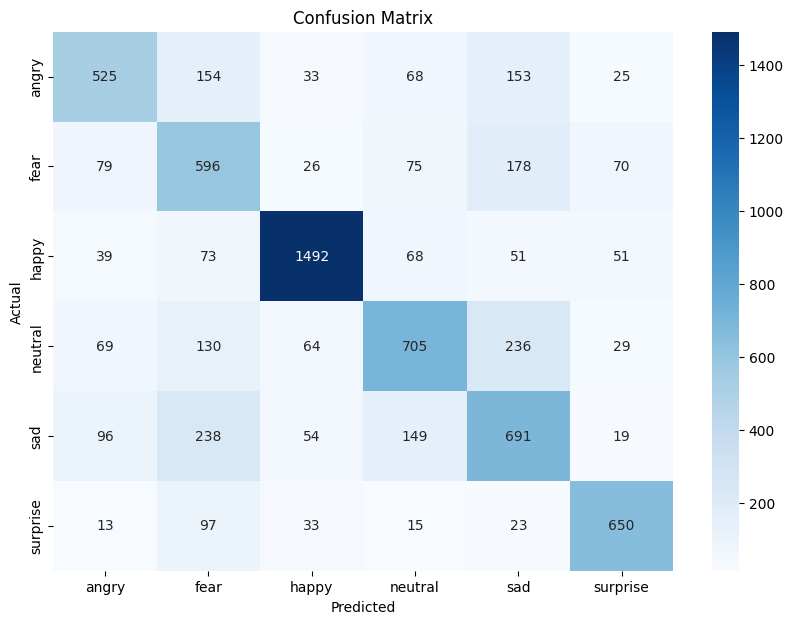

In [75]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Load model
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()
model.to(device) # Move the model to the correct device

# Run inference on validation set
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device) # Move inputs to the correct device
        labels = labels.to(device) # Move labels to the correct device
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds, target_names=filtered_class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=filtered_class_names, yticklabels=filtered_class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

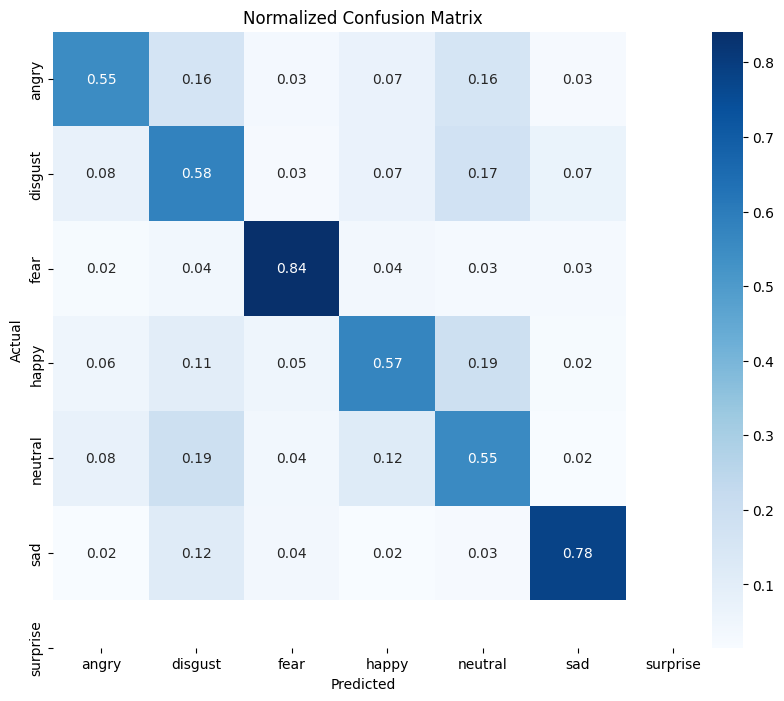

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Normalized Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
